In [10]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
import numpy as np 
import datetime
import math
import vfh_charts
import geopandas as gpd
import os
import shapely
from shapely.geometry import Point
os.environ["PROJ_LIB"]=r"C:\Users\rliu4\AppData\Local\Continuum\anaconda3\Library\share"

CONFIG = configparser.ConfigParser()
CONFIG.read(r'C:\Users\rliu4\Documents\Python\config.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [11]:
mpl.rcParams['figure.dpi'] = 450

In [2]:
query = '''

WITH sum AS (
SELECT extract(month from pickup_datetime) as mon, extract(year from pickup_datetime) as yr, extract(week from pickup_datetime) as wk, pickup_neighbourhood, 
sum(count) as count  FROM ptc.trip_data_agg_neighbourhood
GROUP BY   pickup_datetime, pickup_neighbourhood

), ward1 AS  (

SELECT  avg(count) as count, pickup_neighbourhood from sum
WHERE (yr=2018 AND mon IN (9))
GROUP BY pickup_neighbourhood
ORDER BY count
), ward2 AS  (

SELECT avg(count) as count, pickup_neighbourhood from sum
WHERE (yr=2016 AND mon IN (10))
GROUP BY pickup_neighbourhood
ORDER BY count
)

SELECT pickup_neighbourhood,  geom, (b.count - a.count)/(a.count)*100 as growth FROM ward2 a 
LEFT JOIN ward1 b USING ( pickup_neighbourhood)
LEFT JOIN gis.neighbourhood ON area_s_cd::integer=pickup_neighbourhood

'''

data = gpd.GeoDataFrame.from_postgis(query, con, geom_col='geom')
data = data.to_crs({'init' :'epsg:3857'})

for index, row in data.iterrows():
    rotated = shapely.affinity.rotate(row['geom'], angle=-17, origin = Point(0, 0))
    data.at[index, 'geom'] = rotated

In [3]:
data=data[['geom', 'growth']]

c:\users\rliu4\appdata\local\continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Libre Franklin SemiBold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
c:\users\rliu4\appdata\local\continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Libre Franklin'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


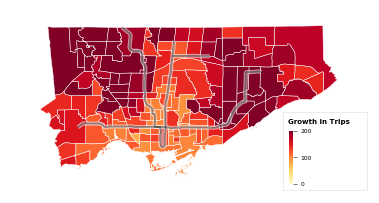

In [4]:
fig, ax = vfh_charts.charts.chloro_map(con, data, subway = True, lower = 0, upper = 200, title = 'Growth in Trips')

c:\users\rliu4\appdata\local\continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Libre Franklin SemiBold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
c:\users\rliu4\appdata\local\continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Libre Franklin'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


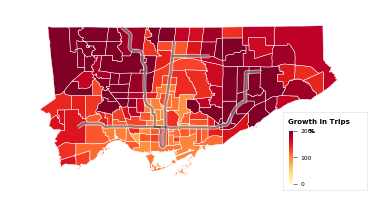

In [12]:
ax.text(0.833, 0.32, '%', transform=ax.transAxes, wrap = True, fontsize=6, fontname = 'Libre Franklin',
                verticalalignment='bottom', ha = 'left') 
fig

In [17]:
fig.rcParams['figure.dpi'] = 450

AttributeError: 'Figure' object has no attribute 'rcParams'

c:\users\rliu4\appdata\local\continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Libre Franklin SemiBold'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
c:\users\rliu4\appdata\local\continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Libre Franklin'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


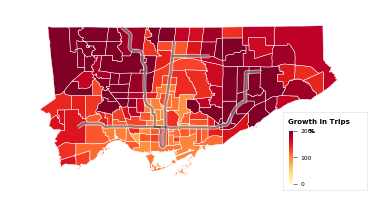

In [16]:
fig